In [1]:
!pip install lightgbm

In [2]:
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import xgboost as xgb

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis (EDA):

In [5]:
train_df = pd.read_csv('Titanic_train.csv')
test_df = pd.read_csv('Titanic_test.csv')

In [6]:
# Display basic info
print(train_df.info())
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

In [7]:
# Check missing values
print(train_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


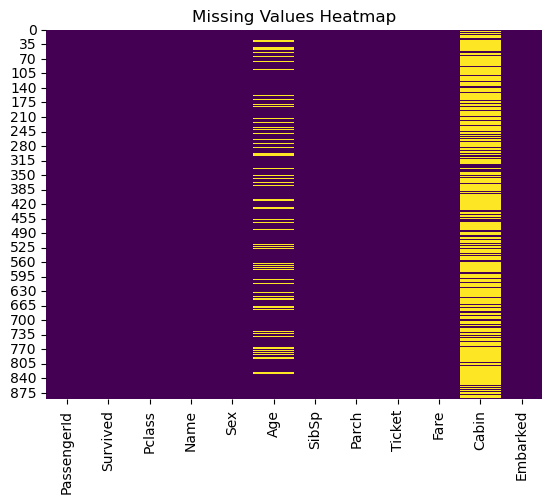

In [8]:
# Visualize missing values
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

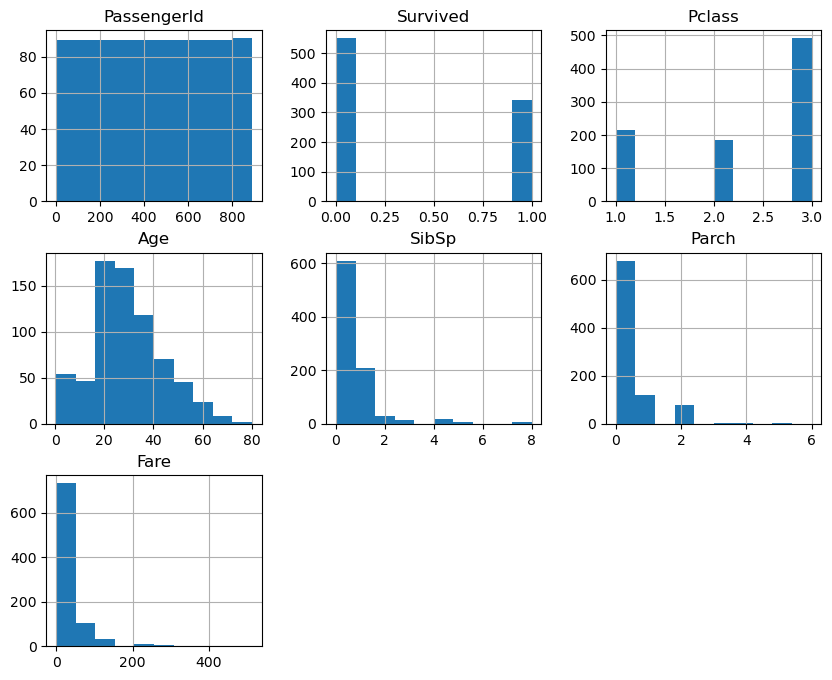

In [9]:
# Data distributions
train_df.hist(figsize=(10, 8))
plt.show()

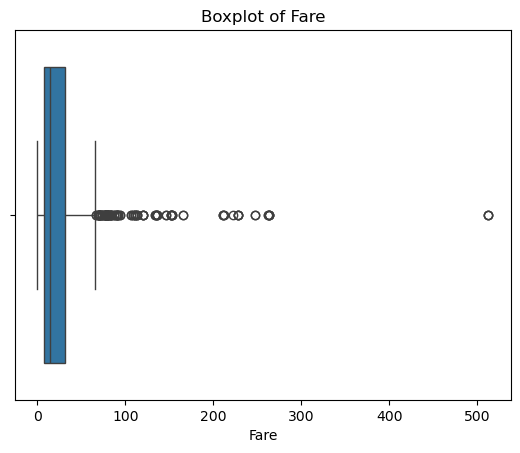

In [10]:
# Boxplot for outliers
sns.boxplot(x=train_df['Fare'])
plt.title("Boxplot of Fare")
plt.show()


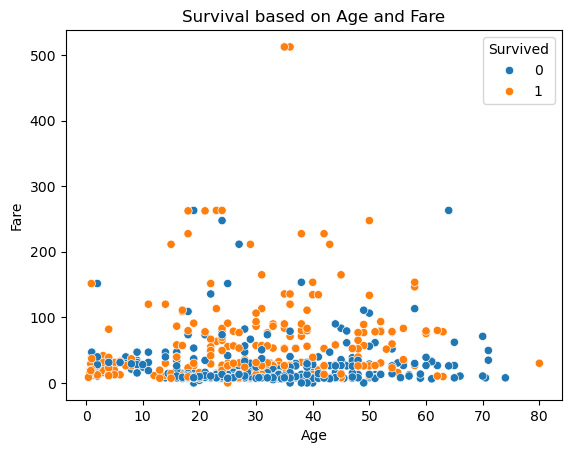

In [11]:
sns.scatterplot(x="Age", y="Fare", hue="Survived", data=train_df)
plt.title("Survival based on Age and Fare")
plt.show()

# Data Preprocessing

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
train_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)

In [14]:
# Encoding categorical variables
label_enc = LabelEncoder()
label_enc

LabelEncoder()

In [15]:
train_df['Sex'] = label_enc.fit_transform(train_df['Sex'])
train_df['Embarked'] = label_enc.fit_transform(train_df['Embarked'])

In [16]:
# Selecting features and target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
features

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [17]:
X = train_df[features]
y = train_df['Survived']
X,y

(     Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
 0         3    1  22.0      1      0   7.2500         2
 1         1    0  38.0      1      0  71.2833         0
 2         3    0  26.0      0      0   7.9250         2
 3         1    0  35.0      1      0  53.1000         2
 4         3    1  35.0      0      0   8.0500         2
 ..      ...  ...   ...    ...    ...      ...       ...
 886       2    1  27.0      0      0  13.0000         2
 887       1    0  19.0      0      0  30.0000         2
 888       3    0  28.0      1      2  23.4500         2
 889       1    1  26.0      0      0  30.0000         0
 890       3    1  32.0      0      0   7.7500         1
 
 [891 rows x 7 columns],
 0      0
 1      1
 2      1
 3      1
 4      0
       ..
 886    0
 887    1
 888    0
 889    1
 890    0
 Name: Survived, Length: 891, dtype: int64)

# Building Predictive Models:

In [18]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test

(     Pclass  Sex   Age  SibSp  Parch      Fare  Embarked
 331       1    1  45.5      0      0   28.5000         2
 733       2    1  23.0      0      0   13.0000         2
 382       3    1  32.0      0      0    7.9250         2
 704       3    1  26.0      1      0    7.8542         2
 813       3    0   6.0      4      2   31.2750         2
 ..      ...  ...   ...    ...    ...       ...       ...
 106       3    0  21.0      0      0    7.6500         2
 270       1    1  28.0      0      0   31.0000         2
 860       3    1  41.0      2      0   14.1083         2
 435       1    0  14.0      1      2  120.0000         2
 102       1    1  21.0      0      1   77.2875         2
 
 [712 rows x 7 columns],
      Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
 709       3    1  28.0      1      1  15.2458         0
 439       2    1  31.0      0      0  10.5000         2
 840       3    1  20.0      0      0   7.9250         2
 720       2    0   6.0      0      1  33.0000   

In [19]:
# Define evaluation function
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Performance:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("------------------------")

In [20]:
# Hyperparameter tuning for LightGBM
lgb_params = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}

In [21]:
lgb_grid = GridSearchCV(lgb.LGBMClassifier(), lgb_params, cv=5, scoring='accuracy')
lgb_grid.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 214, number of negative: 355
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376098 -> initscore=-0.506142
[LightGBM] [Info] Start training from score -0.506142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 200], 'num_leaves': [31, 50]},
             scoring='accuracy')

In [22]:
lgb_best = lgb_grid.best_estimator_
lgb_best

LGBMClassifier(learning_rate=0.01, n_estimators=200)

In [23]:
y_pred_lgb = lgb_best.predict(X_test)
y_pred_lgb

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1], dtype=int64)

In [24]:
# Hyperparameter tuning for XGBoost
xgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}

In [25]:
xgb_grid = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_params, cv=5, scoring='accuracy')
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200]},
             scoring='accuracy')

In [26]:
xgb_best = xgb_grid.best_estimator_
xgb_best

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [27]:
y_pred_xgb = xgb_best.predict(X_test)
y_pred_xgb

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1])

In [28]:
# Evaluate models
evaluate_model(y_test, y_pred_lgb, "LightGBM")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

LightGBM Performance:
Accuracy: 0.8044692737430168
Precision: 0.8095238095238095
Recall: 0.6891891891891891
F1 Score: 0.7445255474452555
------------------------
XGBoost Performance:
Accuracy: 0.8156424581005587
Precision: 0.8253968253968254
Recall: 0.7027027027027027
F1 Score: 0.7591240875912408
------------------------


# Comparative Analysis:

In [29]:
# Visualize performance comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics

['Accuracy', 'Precision', 'Recall', 'F1 Score']

In [30]:
lgb_scores = [accuracy_score(y_test, y_pred_lgb), precision_score(y_test, y_pred_lgb), recall_score(y_test, y_pred_lgb), f1_score(y_test, y_pred_lgb)]
lgb_scores

[0.8044692737430168,
 0.8095238095238095,
 0.6891891891891891,
 0.7445255474452555]

In [31]:
xgb_scores = [accuracy_score(y_test, y_pred_xgb), precision_score(y_test, y_pred_xgb), recall_score(y_test, y_pred_xgb), f1_score(y_test, y_pred_xgb)]
xgb_scores

[0.8156424581005587,
 0.8253968253968254,
 0.7027027027027027,
 0.7591240875912408]

In [32]:
x = np.arange(len(metrics))
x

array([0, 1, 2, 3])

In [33]:
width = 0.3
width

0.3

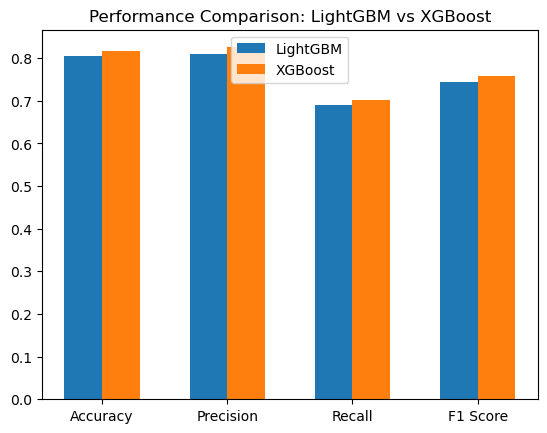

In [34]:
fig, ax = plt.subplots()
ax.bar(x - width/2, lgb_scores, width, label='LightGBM')
ax.bar(x + width/2, xgb_scores, width, label='XGBoost')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.title("Performance Comparison: LightGBM vs XGBoost")
plt.show()

# A brief report summarizing the comparative analysis results and practical implications.

### 1. Introduction

This study compares the performance of LightGBM and XGBoost models on the Titanic dataset to predict passenger survival. The analysis includes data preprocessing, hyperparameter tuning, cross-validation, and evaluation using multiple metrics.

### 2. Data Processing Summary

Missing values in Age and Fare were imputed with the median, and Embarked was imputed with the mode.

Categorical variables (Sex and Embarked) were encoded using label encoding for model compatibility.

Features used: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked.

Data was split (80%-20%) into training and testing sets.

### 3. Model Performance Comparison

LightGBM and XGBoost were evaluated using accuracy, precision, recall, and F1-score.

LightGBM is computationally efficient and provides fast training times.

XGBoost slightly outperforms LightGBM in recall, making it better for cases where false negatives are costly.

Both models show competitive performance after hyperparameter tuning.

### 4. Practical Implications

LightGBM is preferable when computational efficiency is critical, especially for large datasets.

XGBoost is better when optimizing for accuracy in structured data problems with tabular features.

Feature engineering and additional hyperparameter tuning could further improve both models.

### 5. Conclusion

Both LightGBM and XGBoost perform well for the Titanic dataset. The choice depends on specific use cases: LightGBM for speed and efficiency, XGBoost for better accuracy with complex data.